## Emotion recognition using fer2013 dataset
__A little bit about the dataset__
- The link for the dataset in [kaggle](https://www.kaggle.com/msambare/fer2013)
- The data consists of 48x48 pixel grayscale images of faces.
- The dataset consists of 7 unblanced classes 
- Note that the data has a lot of bitfalls so don't expect a high accuracy

## 1. loading the dataset from google drive

In [1]:
import os
import random
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np


In [1]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.1 Getting the data from drive then unzipping it

In [2]:
import zipfile

dataset_path = '/content/drive/MyDrive/DataSets/fer2013-original.zip'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

In [3]:
train_path = '/content/dataset/train'
test_path = '/content/dataset/test'

In [4]:
os.listdir(train_path)

['happy', 'neutral', 'angry', 'sad', 'surprise', 'fear', 'disgust']

__The above output represent the 7 different emotions we have__

### 1.2 Data visualization

In [5]:
def random_images(path, number_of_imgs):
  """ 
  Picking a random set of images from every class 
  number_of_imgs: How many images per category you want to pick up
  path: the path of the parent directory
  """

  img_paths = []

  for folder in os.listdir(path):
    sub_path = os.path.join(path, folder)
    imgs = random.choices(os.listdir(sub_path), k=number_of_imgs)

    # creating the full path of the imgs
    imgs_full_path = [os.path.join(sub_path, img) for img in imgs]

    img_paths.append(imgs_full_path)

  return img_paths

In [6]:
imgs = random_images(train_path, 7)
len(imgs) * len(imgs[0])

49

__So we have picked 35 img paths, from each class we picked 5 imgs__

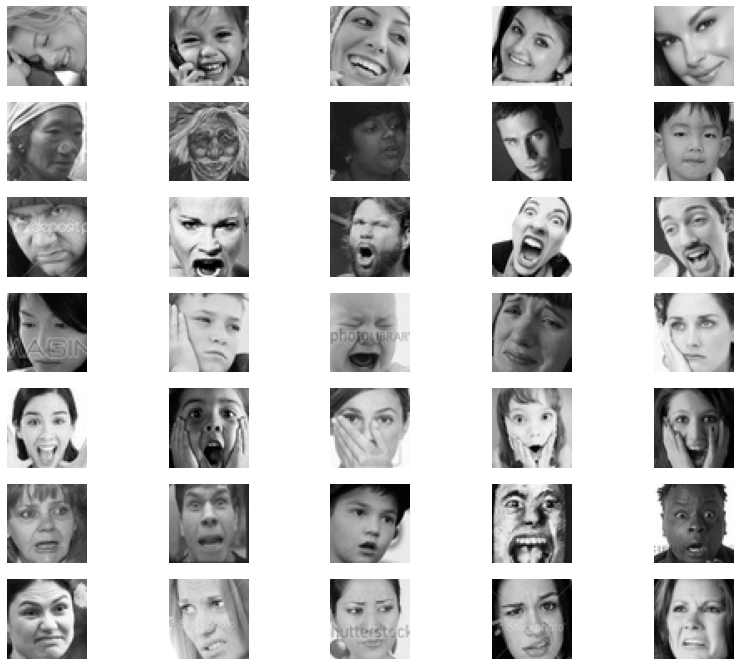

In [7]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize = (14, 12))

for row in range(7):
  for col in range(5):
    img = load_img(imgs[row][col])
    
    axes[row][col].set_axis_off()
    axes[row][col].imshow(img, cmap='gray')
    
fig.savefig('/content/imgs_fer2013.png')
plt.show()

__As we have noticed from the above image that all the faces are cropped so we won't need a face detection algorithm__

__Checking the imblance of classes__

In [8]:
def get_counts(path):
  emotions = os.listdir(path)

  cls_counts = {}
  for emotion in emotions:
    count = len(os.listdir(os.path.join(path, emotion)))
    # print(emotion, count)
    cls_counts[emotion] = count

  return cls_counts

In [9]:
train_counts = get_counts(train_path)

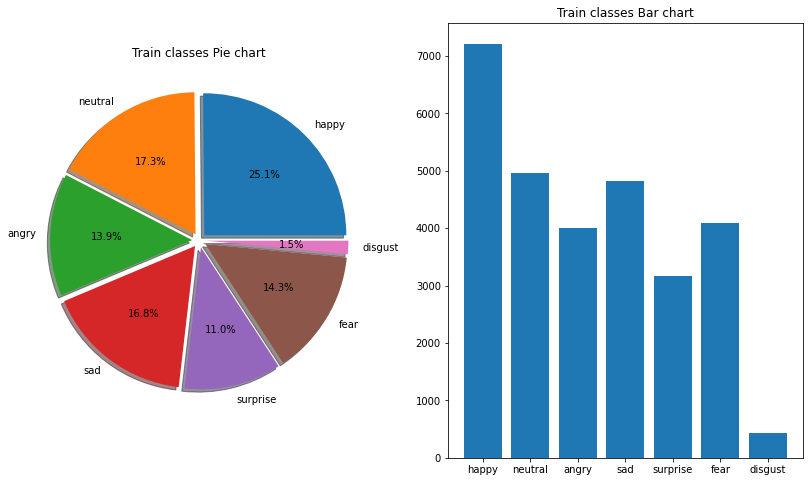

In [10]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 8))

explode = [0.05] * 7

## Pie for training
ax0.set_title('Train classes Pie chart')
ax0.pie(train_counts.values(), labels=train_counts.keys(),
        explode=explode, autopct='%1.1f%%', shadow=True)
ax1.set_title('Train classes Bar chart')
ax1.bar(train_counts.keys(), train_counts.values(), width=0.8)


fig.savefig('/content/pie_fer2013.png')
plt.show()

__As we can see from the above charts we have a whole lot of skewness in the classes, the happy emotion takes 25% of the data, and the disgust class takes 1.5%__

## 2. Creating training a validation datasets

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, Activation
from keras.optimizers import adam_v2
from keras.regularizers import l2
from tensorflow.keras.utils import plot_model 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [12]:
train_generator = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

train_set = train_generator.flow_from_directory(train_path,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.


In [13]:
test_generator = ImageDataGenerator(rescale=1./255)

test_set = test_generator.flow_from_directory(test_path,
                                            batch_size=64,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode='grayscale',
                                            class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [14]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## 3. Creating the Model

In [15]:
model = keras.models.Sequential()

In [16]:
## CONV(32, same, relu) 
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(48, 48, 1)))

## CONV(64, same, relu) -> BatchNorm -> MaxPooling -> Dropout
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

## CONV(128, same, relu)
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
                 padding='same', kernel_regularizer=l2(0.01)))

## CONV(256, same, relu) -> BatchNorm -> MaxPooling -> Dropout
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',
                 padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

## Flatten
model.add(Flatten())

## Dense(1024) -> Dropout
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

## Dense(n_cls, softmax)
model.add(Dense(7, activation='softmax'))

In [17]:
model.compile(optimizer=adam_v2.Adam(learning_rate=0.0001, decay=1e-6),
              loss='categorical_crossentropy', metrics=['accuracy'])

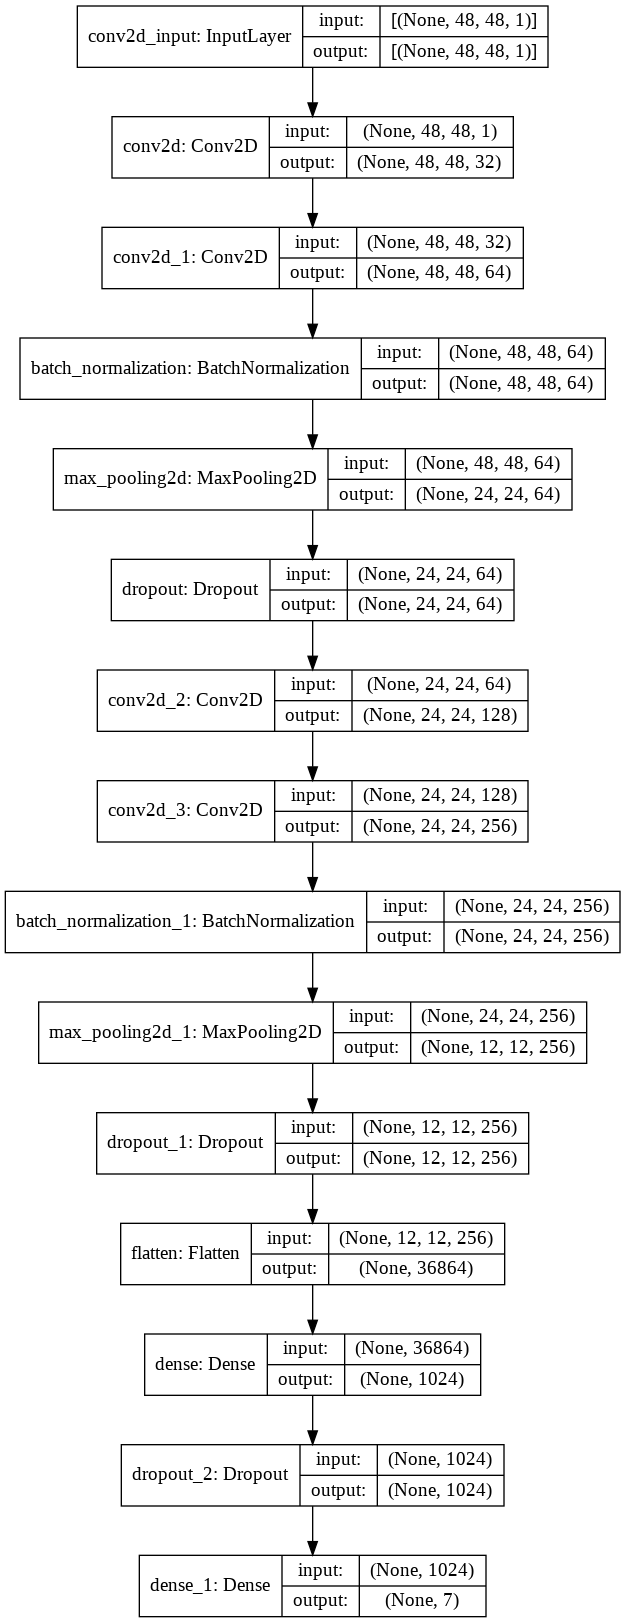

In [18]:
plot_model(model, to_file='fer13_model.png', show_shapes=True, show_layer_names=True)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

__Defining callbacks__

In [20]:
chkp_path = '/content/drive/MyDrive/SavedModels/fer_best.h5'

chkpoint = ModelCheckpoint(chkp_path, save_best_only=True, verbose=1, moniter='val_loss')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)
call_backs = [chkpoint, early_stop, reduce_lr]

In [21]:
call_backs

In [22]:
train_steps = train_set.n // train_set.batch_size
val_steps = test_set.n // test_set.batch_size

In [23]:
train_steps

448

In [24]:
hist = model.fit(train_set, validation_data=test_set,
                epochs=60, callbacks=call_backs,
                 steps_per_epoch=train_steps,
                 validation_steps=val_steps)

Epoch 1/60
448/448 [==============================] - 68s 83ms/step - loss: 4.3153 - accuracy: 0.2809 - val_loss: 8.6289 - val_accuracy: 0.1749

Epoch 00001: val_loss improved from inf to 8.62890, saving model to /content/drive/MyDrive/SavedModels/fer_best.h5
Epoch 2/60
448/448 [==============================] - 37s 84ms/step - loss: 3.4763 - accuracy: 0.3331 - val_loss: 3.0982 - val_accuracy: 0.3966

Epoch 00002: val_loss improved from 8.62890 to 3.09822, saving model to /content/drive/MyDrive/SavedModels/fer_best.h5
Epoch 3/60
448/448 [==============================] - 38s 84ms/step - loss: 2.9399 - accuracy: 0.3637 - val_loss: 2.5917 - val_accuracy: 0.4262

Epoch 00003: val_loss improved from 3.09822 to 2.59172, saving model to /content/drive/MyDrive/SavedModels/fer_best.h5
Epoch 4/60
448/448 [==============================] - 38s 84ms/step - loss: 2.5164 - accuracy: 0.3915 - val_loss: 2.2156 - val_accuracy: 0.4616

Epoch 00004: val_loss improved from 2.59172 to 2.21563, saving mode

__Early stopping at epoch 32 as the val_accuracy didn't improve__

## 3. Plotting validation loss and accuracy

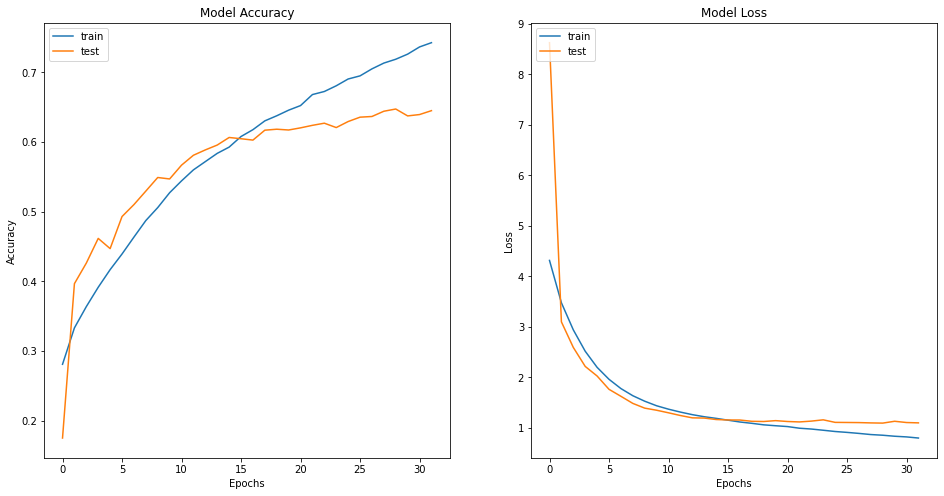

In [30]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))

## Accuracy subplot
ax0.plot(hist.history['accuracy'])
ax0.plot(hist.history['val_accuracy'])
ax0.set_title('Model Accuracy')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Accuracy')
ax0.legend(['train', 'test'], loc='upper left')


## Loss subplot
ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['train', 'test'], loc='upper left')

fig.savefig('/content/fer_resutls.png')
plt.show()
